# Random Forest regression analysis of Ge in combined OSNACA data

In [89]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#read in the data

osnaca = pd.read_excel("../data/osnaca-data.xlsx",sheet_name="Data")
osnaca_conclurry = pd.read_excel("../data/osnaca-data.xlsx",sheet_name="Cloncurry Supplement")
osnaca_metadata_sheet1 = pd.read_excel("../data/osnaca-metadata.xlsx",sheet_name="Ore samples")

In [4]:
osnaca.head()

,Sample,Code,Au (FA),Pt,Pd,Au (AR),Bi,Te,Hg,Ag,...,Y,Zn,B,Hf,Si,Zr,Be,Ga,Ge,Wt Tot
0,700001,NaN,0.438,0.002,0.002,0.362,10.60,0.02,0.39,91.5,...,1.2,153000,-20,0.4,34200,60,-1.0,11.0,1,159
1,700002,NaN,0.093,0.001,0.002,0.095,125.00,0.22,0.12,44.0,...,18.5,3780,-20,0.2,114000,20,-1.0,2.0,-1,143
2,700003,NaN,1.41,0.002,0.002,1.39,120.00,0.02,62.9,215.0,...,0.3,219000,-20,-0.2,71500,-10,-1.0,-1.0,2,204
3,700004,1,0.096,0.003,0.005,0.086,0.72,0.80,0.03,2.5,...,6.3,755,-20,2.0,244000,70,-1.0,-1.0,-1,185
4,700005,NaN,2.9,0.003,0.005,3.94,0.34,0.06,4.01,162.0,...,4.5,173000,-20,-0.2,142000,-10,-1.0,-1.0,2,280


In [5]:
osnaca_conclurry.head()

,Sample,Code,Code Tester,Au1,Pt,Pd,Au(AR),Bi,Te,Hg,...,Y,Zn,B,Hf,Si,Zr,Be,Ga,Ge,Wt Total
0,ALT010,NaN,NaN,0.039,0.002,-0.001,NaN,1.20,0.44,12.80,...,7.1,6760,-20,1.2,91800,40,4.2,16.6,4,164.0
1,ALT024,NaN,NaN,0.011,-0.001,0.002,NaN,0.20,0.10,0.02,...,14.6,1390,-20,22.0,64300,900,12.2,25.8,3,140.0
2,ALT073,NaN,NaN,0.436,0.004,0.007,NaN,0.30,0.22,1.30,...,15.1,1510,-20,2.0,127000,70,17.0,32.4,12,109.0
3,ALT074,NaN,NaN,0.508,0.002,0.002,NaN,24.70,1.80,3.91,...,3.6,14500,20,0.4,40300,4,0.9,5.6,1,NaN
4,ART013,1.0,1.0,-0.001,0.001,-0.001,NaN,0.08,-0.02,-0.01,...,41.0,225,80,5.6,248000,156,6.0,33.4,1,NaN


### Merge two first sheets

In [6]:
set(osnaca.columns).difference(set(osnaca_conclurry.columns))

{'Au (AR)', 'Au (FA)', 'Wt Tot'}

In [7]:
set(osnaca_conclurry.columns).difference(set(osnaca.columns))

{'Au(AR)', 'Au1', 'Code Tester', 'Wt Total'}

In [8]:
#assumed Au1 = Au (FA)
osnaca_cloncurry = osnaca_conclurry.rename(columns={"Wt Total": "Wt Tot", "Au(AR)": "Au (AR)", "Au1": "Au (FA)"})
osnaca_cloncurry = osnaca_cloncurry.drop(['Code Tester'], axis = 1)

In [9]:
#merge the Cloncurry data with the other samples
osnaca_all = pd.concat([osnaca, osnaca_cloncurry])

In [14]:
#conclurry rows successfully contatenated
print(osnaca.shape, osnaca_cloncurry.shape, osnaca_all.shape)

(1139, 69) (72, 69) (1211, 69)


Highest Associates of Ge appear to be Zn, Cd, S and Tl as seen below in both combined and single dataset

In [19]:
#using combined dataset doesn't notably change correlations with Ge at first glance
osnaca_all.corr()['Ge'].sort_values(ascending=False)

Ge    1.000000
Zn    0.496282
Cd    0.226739
S     0.198342
Tl    0.179400
        ...   
K    -0.095798
Na   -0.102637
Ti   -0.116100
Al   -0.139017
Si   -0.185344
Name: Ge, Length: 61, dtype: float64

In [17]:
osnaca.corr()['Ge'].sort_values(ascending=False)

Ge    1.000000
Zn    0.494664
Cd    0.224266
S     0.202368
Tl    0.177224
        ...   
K    -0.098204
Na   -0.103530
Ti   -0.119651
Al   -0.143311
Si   -0.195223
Name: Ge, Length: 62, dtype: float64

## Data Cleaning

Remove Na values for RF regressor

Deal with negative values, by converting it to half the absolute value

In [ ]:
# IS values in dataset need to be converted to Na values



In [53]:
#missing values need to be removed, Code and Wt Tot columnns can be removed as they aren't useful features, meaning 72 rows will be removed
osnaca_all.isna().sum()[osnaca_all.isna().sum() > 0]

Code       994
Au (AR)     72
Wt Tot     617
dtype: int64

In [54]:
#drop code and wt tot columns
#drop sample column as it is not a useful feature
osnaca_all2 = osnaca_all.drop(['Code', 'Wt Tot', 'Sample'], axis=1)
osnaca_all2.isna().sum()[osnaca_all2.isna().sum() > 0]

Au (AR)    72
dtype: int64

In [55]:
#remove values that are 'IS'
osnaca_all2=osnaca_all2[osnaca_all2 != 'IS']

C:\Users\caley\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [56]:
#drop 72 rows
osnaca_all2 = osnaca_all2.dropna()
osnaca_all2.isna().sum()[osnaca_all2.isna().sum() > 0]

Series([], dtype: int64)

In [57]:
#1135 rows remain
osnaca_all2.shape

(1135, 66)

## Random Forest

In [58]:
from sklearn.ensemble import RandomForestRegressor


#split dataset into features and output variable
X = osnaca_all2.drop(['Ge'], axis=1)
y = osnaca_all2['Ge']

In [59]:
#split data into train and test set
import sklearn.model_selection as selection

X_train, X_test, y_train, y_test = selection.train_test_split(X, y, test_size = 0.25, random_state = 0)

In [65]:
#specify regression model
regressor = RandomForestRegressor(n_estimators=500, random_state=0)


In [66]:
#fit to training data 
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=0)

In [67]:
#predictions for training and test data set
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)


In [68]:
#evaluating random forest
from sklearn import metrics
print('Training Error')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train,y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train,y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print("")

print('Testing Error')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred_test)))

Training Error
Mean Absolute Error: 2.0208813160987074
Mean Squared Error: 43.21029721739131
Root Mean Squared Error: 6.573453979255602

Testing Error
Mean Absolute Error: 5.278190140845071
Mean Squared Error: 146.1675745774648
Root Mean Squared Error: 12.089978270347089


## Feature Importances

In [79]:
#Feature importances
for name, score in zip(X_train.columns, regressor.feature_importances_):
    print(name, score)

Au (FA) 0.009416745201942113
Pt 0.0006522822087701138
Pd 0.0010509083890617185
Au (AR) 0.010886407475641955
Bi 0.009993254328143087
Te 0.004722904481260628
Hg 0.007312842569380792
Ag 0.007802244142129938
Al 0.003306072780281539
As 0.005533311448606364
Ca 0.015390499885901295
Cd 0.01405961957713294
Co 0.009186939226017172
Cr 0.00018349778465703978
Cs 0.01794279470013903
Cu 0.011772963578558924
Fe 0.006965527362297047
In 0.005072315994729995
K 0.003526032939331672
La 0.016648918386921008
Ce 0.015471218906090153
Pr 0.004161739625463887
Nd 0.01113976754179891
Sm 0.008586144168293319
Eu 0.0020389861837726312
Gd 0.0016060532342978071
Tb 0.0008211096375496304
Dy 0.0014752833688117504
Ho 0.0008267622526913856
Er 0.0007552121173642071
Tm 0.0008514221639139176
Yb 0.0031175471762092113
Lu 0.004205435095077924
Li 0.008175589224526245
Mg 0.009339288909145062
Mn 0.020361304210521087
Mo 0.007529666727310663
Na 0.003433766687449599
Nb 0.001485249258580049
Ni 0.004958409351773244
P 0.002052780312000724

In [99]:
# Visualising some predictions

# model predictions
xt = X_train[:50]
pred1 = regressor.predict(xt)

In [100]:
#true values
xt_test = np.array(y_train[:50])
xt_test

array([ 2,  1,  4, -1,  2, 14, 20, 46, -1,  3, -1,  2,  2,  3,  2,  3,  3,
        4, -1,  3,  4,  2, 43,  1,  2,  1,  1,  3,  2, 67,  2,  6,  3,  1,
        1, -1,  2,  3, 83,  1,  6,  5,  1, -1,  2, 30,  1, 55, -1,  3],
      dtype=int64)

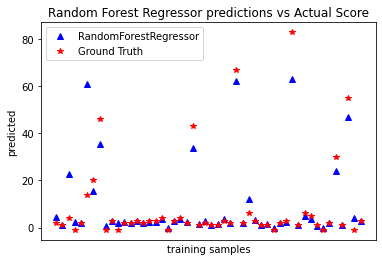

In [101]:
plt.figure()
plt.plot(pred1, 'b^', label = 'RandomForestRegressor')
plt.plot(xt_test, 'r*', label = 'Ground Truth')

plt.tick_params(axis='x', which = 'both', bottom = False, top=False, labelbottom=False)

plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc='best')
plt.title('Random Forest Regressor predictions vs Actual Score')
plt.show()